# Imports/Setup and Helper Functions

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import math
import time
import seaborn as sns


### Helper Functions

In [3]:
def int2analog(x, n=10):
    # Convert an integer to a PyTorch tensor
    x_tensor = torch.tensor([x], dtype=torch.int32)

    # Convert integers into the corresponding binary bits.
    shifts = torch.arange(n - 1, -1, -1, dtype=x_tensor.dtype)
    x_tensor = torch.bitwise_right_shift(x_tensor, shifts)
    x_tensor = torch.remainder(x_tensor, 2)

    # Convert the binary bits into the corresponding analog values.
    x_tensor = x_tensor.type(torch.float32)
    x_tensor = 2 * x_tensor - 1


    return x_tensor 

def analog2int(x):
    # Convert an analog bit representation back to an integer
    x = (x + 1) / 2  # Convert from [-1, 1] to [0, 1]
    x = torch.round(x).type(torch.int32)  # Round and convert to int
    # Convert binary bits back to integer
    int_val = 0
    for i, bit in enumerate(reversed(x)):
        int_val += bit.item() * (2 ** i)
    return int_val


def visualize_sequence(sequence, title=""):
    """
    Visualizes a sequence as an image.

    Args:
    - sequence (torch.Tensor): A tensor of shape (9,) representing a sequence.
    - title (str): Title of the image.
    """

    # Convert sequence to a numpy array
    if isinstance(sequence, torch.Tensor):
        sequence = sequence.cpu().detach().numpy()


    # Reshape sequence to (1, 9) and transpose it to (9, 1)
    sequence = sequence.reshape((9, 1)).T

    # Map noisy sequences from [-1, 1] to [0, 1] and clip
    sequence = np.clip(sequence, -1, 1)

    # Plot the noisy sequences
    plt.figure(figsize=(9, 1))
    plt.imshow(sequence, cmap="gray", vmin=0, vmax=1)
    plt.title(title)
    plt.show()


#visualize 10 noisy sequences in a grid
def visualize_noisy_sequences(noisy_sequences, title=""):
    """
    Visualizes a list of noisy sequences as a 10x9 grid of images. Maps sequences from [-1, 1] to [0, 1] and clips values out of bounds.
    """
    # Convert noisy sequences to a numpy array
    noisy_sequences = [seq.numpy() for seq in noisy_sequences]

    # Reshape noisy sequences to a 10x9 grid
    noisy_sequences = np.array(noisy_sequences).reshape((10, 9))

    # Map noisy sequences from [-1, 1] to [0, 1] and clip
    #noisy_sequences = np.clip(noisy_sequences, -1, 1)

    #determine vmin and vmax
    vmin = np.min(noisy_sequences)
    vmax = np.max(noisy_sequences)
    # Plot the noisy sequences
    plt.figure(figsize=(9, 10))
    plt.imshow(noisy_sequences, cmap="gray", vmin=-1, vmax=1)
    plt.title(title)
    plt.show()


# Taxi Dataset & Preprocessing


In [4]:
path = 'taxi_medium-expert_dataset.csv'

# Dataset format:
# (state, action, reward, next_state, done)

# Load the dataset into torch (remove the header line and convert true/false to 0/1)
data = np.loadtxt(path, delimiter=',', skiprows=1, converters={4: lambda x: int(x == 'True')})

print("Dataset Shape: ", data.shape)
print("Sample data: ", data[1])

#function to convert the data into analog bits (500 states so we need 9 bits)
# Ex. [5. 1. -1. 3. 0.] -> [[-1. -1. -1. -1. -1. -1. 1. -1. 1.], [-1. -1. -1. -1. -1. -1. -1. 1. 1.], -1., [-1. -1. -1. -1. -1. -1. -1. 1. 1.], 0.]

def convert_data(data):
    #convert the data into analog bits
    analog_data = []
    for i in range(data.shape[0]):
        analog_state = []
        for j in range(data.shape[1]):
            #if action only use 3 bits (6 possible actions)
            if j == 1:
                analog_state.append(int2analog(data[i][j], 3))
            else:
                analog_state.append(int2analog(data[i][j], 9))
        analog_data.append(analog_state)

    #convert the reward and done back to int
    for i in range(data.shape[0]):
        analog_data[i][2] = torch.tensor(data[i][2], dtype=torch.float32)
        analog_data[i][4] = torch.tensor(data[i][4], dtype=torch.float32)
        
    return analog_data

analog_data = convert_data(data)
# change from list to appropriate format


print("Analog Dataset len: ", len(analog_data))
print("Sample analog bit data: ", analog_data[1])






Dataset Shape:  (147973, 5)
Sample data:  [174.   0.  -1. 274.   0.]
Analog Dataset len:  147973
Sample analog bit data:  [tensor([-1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.]), tensor([-1., -1., -1.]), tensor(-1.), tensor([ 1., -1., -1., -1.,  1., -1., -1.,  1., -1.]), tensor(0.)]


In [5]:
class AnalogDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        state, action, reward, next_state, done = self.data[idx]
        return state, action, reward, next_state, done


# Create the dataset
dataset = AnalogDataset(analog_data)

# from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

#test the dataloader
for state, action, reward, next_state, done in dataloader:
    print("State batch shape: ", state.shape)
    print("Action batch shape: ", action.shape)
    print("Reward batch shape: ", reward.shape)
    print("Next State batch shape: ", next_state.shape)
    print("Done batch shape: ", done.shape)
    break


State batch shape:  torch.Size([32, 9])
Action batch shape:  torch.Size([32, 3])
Reward batch shape:  torch.Size([32])
Next State batch shape:  torch.Size([32, 9])
Done batch shape:  torch.Size([32])


# Network Architecture

In [6]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

In [7]:
class MLP(nn.Module):
    def __init__(self, state_dim, action_dim, bit_dim, time_embedding_dim, hidden_dim=64):
        super(MLP, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.bit_dim = bit_dim
        self.time_embedding_dim = time_embedding_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #if torch.backends.mps.is_available(): self.device = torch.device("mps")

        

        # Time Embedding Layer
        self.time_embedding = SinusoidalPosEmb(time_embedding_dim)

        # Input dimension: state dimension + bit-encoded action dimension + time embedding dimension
        input_dim = state_dim + bit_dim + time_embedding_dim

        # Define the MLP layers
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Mish(),
            nn.Linear(hidden_dim, bit_dim)  # Output dimension is the bit-encoded action dimension
        )

    def forward(self, state, time, bit_action):
        # Generate time embedding
        time_emb = self.time_embedding(time)

        # Reshape time_emb to match the batch size of state and bit_action
        time_emb = time_emb.expand(state.size(0), -1)

        # Concatenate state, time embedding, and bit-encoded action
        x = torch.cat([state, time_emb, bit_action], dim=-1)

        # Pass through the MLP layers
        return self.layers(x)


# Diffusion Process
The DDPM paper describes a corruption process that adds a small amount of noise for every 'timestep'. Given $x_{t-1}$ for some timestep, we can get the next (slightly more noisy) version $x_t$ with:<br><br>

$q(\mathbf{x}_t \vert \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t\mathbf{I}) \quad
q(\mathbf{x}_{1:T} \vert \mathbf{x}_0) = \prod^T_{t=1} q(\mathbf{x}_t \vert \mathbf{x}_{t-1})$<br><br>


That is, we take $x_{t-1}$, scale it by $\sqrt{1 - \beta_t}$ and add noise scaled by $\beta_t$. This $\beta$ is defined for every t according to some schedule, and determines how much noise is added per timestep. To save time, there is a faster formula that computes all the timesteps simultaneously: <br><br>

$\begin{aligned}
q(\mathbf{x}_t \vert \mathbf{x}_0) &= \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, {(1 - \bar{\alpha}_t)} \mathbf{I})
\end{aligned}$ where $\bar{\alpha}_t = \prod_{i=1}^T \alpha_i$ and $\alpha_i = 1-\beta_i$<br><br>


In [10]:
def cosine_beta_schedule(T, s=0.1):
    """
    Generate a cosine beta schedule for T timesteps.

    Args:
    - T (int): The number of timesteps in the diffusion process.
    - s (float): A hyperparameter controlling the sharpness of the cosine curve. Typical values are between 0.001 and 0.1.

    Returns:
    - betas (torch.Tensor): A tensor of beta values for the diffusion schedule.
    """
    # Define the steps
    steps = torch.arange(0, T, dtype=torch.float32) / T

    # Calculate the alphas using the cosine schedule
    alphas = torch.cos(((steps + s) / (1 + s)) * np.pi * 0.5) ** 2
    alphas = alphas / alphas[0]

    # Calculate beta values from alphas
    betas = 1 - alphas[1:] / alphas[:-1]
    
    # Ensure that beta values are within a valid range
    betas = torch.clip(betas, 0.0001, 0.9999)

    if len(betas) < T:
        last_beta = betas[-1]
        betas = torch.cat([betas, last_beta.unsqueeze(0)])

    #print("BETA SCHEDULE: ", betas)

    return betas

def compute_alpha_bar(beta_schedule):
    alpha = 1. - beta_schedule
    alpha_bar = torch.cumprod(alpha, dim=0)
    return alpha, alpha_bar


def apply_noise(x, timestep, beta_schedule):
    """
    Applies noise to an action x at a specific timestep.

    Args:
    - x (torch.Tensor): The initial action tensor.
    - timestep (int): The specific timestep at which to apply noise.
    - beta_schedule (torch.Tensor): The beta schedule tensor.

    Returns:
    - torch.Tensor: The noised version of the action at the specified timestep.
    """
    # Compute alpha and alpha_bar
    alpha, alpha_bar = compute_alpha_bar(beta_schedule)

    # Add noise to the action at the specified timestep
    epsilon = torch.randn_like(x)
    xt = torch.sqrt(alpha_bar[timestep]) * x + torch.sqrt(1. - alpha_bar[timestep]) * epsilon

    return xt


def make_data_to_plot(T, beta_schedule=False, s=0):
    #if beta_schedule is not a tensor, make one
    if type(beta_schedule) == bool:
        if beta_schedule == False:
            beta_schedule = torch.linspace(1e-4, 0.02, T)
        else:
            beta_schedule = cosine_beta_schedule(T, s=s)

    x_to_plot = []
    xt = torch.tensor([-1., -1., -1., -1., 0. , 1. , 1. , 1. , 1.])
   #0 tensor
    #xt = torch.tensor([0., 0., 0., 0., 0. , 0. , 0. , 0. , 0.])  # Initial image

    x_to_plot.append(xt)

    for t in range(T):
        xt = apply_noise(xt, t, beta_schedule)
        #we want to keep T/10 timesteps
        if t % (T/10) == 0 and t > 0:    
            x_to_plot.append(xt)

    return x_to_plot    


    
def reverse_diffusion(x_noisy, timestep, model, state, beta_schedule):
    """
    Performs a single reverse diffusion step.

    Args:
    - x_noisy (torch.Tensor): The current noisy version of the action data.
    - timestep (int): The current timestep in the reverse diffusion process.
    - model (nn.Module): The neural network model used for denoising.
    - state (torch.Tensor): The current state of the environment.
    - beta_schedule (torch.Tensor): The beta schedule tensor.

    Returns:
    - torch.Tensor: The denoised version of the action data after the reverse diffusion step.
    """
    alpha, alpha_bar = compute_alpha_bar(beta_schedule)

    # Convert timestep to a tensor
    timestep_tensor = torch.tensor([timestep], dtype=torch.float32, device=model.device)

    # Generate model output
    model_output = model(x_noisy, timestep_tensor, state)

    x_denoised = (x_noisy - torch.sqrt(1. - alpha_bar[timestep]) * model_output) / torch.sqrt(alpha_bar[timestep])
    return x_denoised


### Diffusion Class

In [11]:
class BitDiffusion(nn.Module):
    def __init__(self, state_dim, action_dim, bit_dim, model, T=100):
        super(BitDiffusion, self).__init__()
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.bit_dim = bit_dim
        self.model = model  # The neural network for denoising
        self.beta_schedule = cosine_beta_schedule(T)  # Define T as needed
        #get mps or cpu or gpu
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #if torch.backends.mps.is_available(): self.device = torch.device("mps")

        #print initiation of model
        print("BitDiffusion Model Initiated with device ", self.device)


    def forward_diffusion(self, x, t):
        """
        Applies forward diffusion to the bit-encoded actions.

        Args:
        - x (torch.Tensor): The bit-encoded actions.
        - t (int): The current timestep for diffusion.

        Returns:
        - torch.Tensor: The noised version of the bit-encoded actions.
        """
        return apply_noise(x, t, self.beta_schedule)

    def reverse_diffusion(self, x_noisy, t, state):
        """
        Performs reverse diffusion to denoise the bit-encoded actions.

        Args:
        - x_noisy (torch.Tensor): The current noisy version of the bit-encoded actions.
        - t (int): The current timestep in the reverse diffusion process.
        - state (torch.Tensor): The current state of the environment.

        Returns:
        - torch.Tensor: The denoised version of the bit-encoded actions.
        """
        return reverse_diffusion(x_noisy, t, self.model, state, self.beta_schedule)

    def sample(self, state, shape):
        """
        Generates a sample (bit-encoded action) given a state.

        Args:
        - state (torch.Tensor): The current state of the environment.
        - shape (tuple): The shape of the tensor to generate.

        Returns:
        - torch.Tensor: The generated bit-encoded action.
        """
        batch_size = shape[0]
        x = torch.randn(shape)  # Start with random noise
        for t in reversed(range(0, self.beta_schedule.size(0))):
            x = self.reverse_diffusion(x, t, state)
        return x


# Training

In [12]:
state_dim = 9  # Dimension of the state vector
bit_dim = 3    # Dimension of the bit-encoded action vector
action_dim = 6 # Dimension of the action vector
hidden_dim = 64  # Number of neurons in each hidden layer
time_embedding_dim = 8  # Dimension of the time embedding

# Instantiate the MLP model
mlp_model = MLP(state_dim, action_dim, bit_dim, time_embedding_dim, hidden_dim)

# Instantiate the Diffusion model
diffusion_model = BitDiffusion(state_dim, action_dim, bit_dim, mlp_model, T=50)

batch_size = 256  # You can adjust this based on your computational resources
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 500  # Number of epochs to train for





BitDiffusion Model Initiated with device  cpu


In [54]:
#load model
diffusion_model = torch.load('3250-taxi-mixed.pt')
num_epochs = 250  # Number of epochs to train for


In [55]:
optimizer = optim.Adam(diffusion_model.parameters(), lr=1e-4)

# Training loop
time_start = time.time()

for epoch in range(num_epochs):
    total_loss = 0
    for state, bit_action, reward, next_state, done in dataloader:
        optimizer.zero_grad()

        # Forward diffusion step
        timestep = torch.randint(0, diffusion_model.beta_schedule.size(0), (1,)).item()    #Make sure the timesteps are good
        noised_action = diffusion_model.forward_diffusion(bit_action, timestep)

        # Reverse diffusion (denoising)
        denoised_action = diffusion_model.reverse_diffusion(noised_action, timestep, state)

        # Loss computation (MSE loss for behavior cloning)
        loss = F.mse_loss(denoised_action, bit_action)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

time_end = time.time()
print(f"Training time: {time_end - time_start:.2f}s")


Epoch 1/250, Average Loss: 0.0992
Epoch 2/250, Average Loss: 0.1272
Epoch 3/250, Average Loss: 0.1001
Epoch 4/250, Average Loss: 0.0922
Epoch 5/250, Average Loss: 0.0993
Epoch 6/250, Average Loss: 0.0969
Epoch 7/250, Average Loss: 0.1288
Epoch 8/250, Average Loss: 0.1144
Epoch 9/250, Average Loss: 0.0976
Epoch 10/250, Average Loss: 0.1052
Epoch 11/250, Average Loss: 0.1023
Epoch 12/250, Average Loss: 0.1289
Epoch 13/250, Average Loss: 0.0997
Epoch 14/250, Average Loss: 0.1006
Epoch 15/250, Average Loss: 0.1036
Epoch 16/250, Average Loss: 0.1156
Epoch 17/250, Average Loss: 0.1008
Epoch 18/250, Average Loss: 0.0894
Epoch 19/250, Average Loss: 0.0958
Epoch 20/250, Average Loss: 0.1263
Epoch 21/250, Average Loss: 0.1004
Epoch 22/250, Average Loss: 0.1068
Epoch 23/250, Average Loss: 0.0953
Epoch 24/250, Average Loss: 0.1156
Epoch 25/250, Average Loss: 0.1851
Epoch 26/250, Average Loss: 0.0931
Epoch 27/250, Average Loss: 0.0979
Epoch 28/250, Average Loss: 0.0945
Epoch 29/250, Average Loss: 0

In [56]:
#save model to "7K_T50_model.pt"
torch.save(diffusion_model, "3500-taxi-mixed.pt")

# Test Model

In [94]:
def sample_action(model, state, T=1):
    """
    Generate a bit-encoded action for a given state using the trained model.

    Args:
    - model (BitDiffusion): The trained diffusion model.
    - state (torch.Tensor): The state tensor.

    Returns:
    - torch.Tensor: The generated bit-encoded action.
    """
    with torch.no_grad():
        # Prepare the state tensor (ensure it's the right shape)
        state = state.to(model.device).unsqueeze(0)  # Add batch dimension if necessary

        # Generate a sample action
        # Total number of timesteps
        sample_shape = (1, model.bit_dim)
        #random action to start reverse diffusion
        sampled_action = torch.randn(sample_shape).to(model.device)
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("x_0: ", sampled_action)
        #actually we need to loop through T timesteps
        for t in range(T):
            if t == T-1:
                sampled_action = model.reverse_diffusion(sampled_action, t, state).squeeze(0)
                print("x_", t+1, ": ", sampled_action)

                return sampled_action
            sampled_action = model.reverse_diffusion(sampled_action, t, state)
            print("x_", t+1, ": ", sampled_action)

            #print("Sampled Action: ", sampled_action)

        return sampled_action


In [353]:
diffusion_model = torch.load('5K-taxi-mixed.pt')

In [382]:
sample = sample_action(diffusion_model, int2analog(108, 9), T=50)
print("Sampled Action: ", sample)
print("Sampled Action: ", analog2int(sample))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
x_0:  tensor([[-1.2228,  1.3992, -0.2338]])
x_ 1 :  tensor([[-1.1836,  1.2507, -0.3216]])
x_ 2 :  tensor([[-1.1392,  1.0542, -0.4327]])
x_ 3 :  tensor([[-1.0981,  0.8445, -0.5429]])
x_ 4 :  tensor([[-1.0637,  0.6447, -0.6373]])
x_ 5 :  tensor([[-1.0380,  0.4649, -0.7093]])
x_ 6 :  tensor([[-1.0221,  0.3064, -0.7589]])
x_ 7 :  tensor([[-1.0156,  0.1693, -0.7891]])
x_ 8 :  tensor([[-1.0144,  0.0564, -0.8028]])
x_ 9 :  tensor([[-1.0133, -0.0301, -0.8018]])
x_ 10 :  tensor([[-1.0094, -0.0947, -0.7905]])
x_ 11 :  tensor([[-1.0037, -0.1475, -0.7768]])
x_ 12 :  tensor([[-0.9991, -0.1983, -0.7670]])
x_ 13 :  tensor([[-0.9977, -0.2495, -0.7630]])
x_ 14 :  tensor([[-0.9981, -0.2948, -0.7608]])
x_ 15 :  tensor([[-0.9964, -0.3281, -0.7537]])
x_ 16 :  tensor([[-0.9912, -0.3528, -0.7405]])
x_ 17 :  tensor([[-0.9843, -0.3776, -0.7282]])
x_ 18 :  tensor([[-0.9789, -0.4090, -0.7229]])
x_ 19 :  tensor([[-0.9766, -0.4465, -0.7245]])
x_ 20 :  tensor([[-0.9759, -0.481

In [52]:
#load model 
diffusion_model = torch.load('3250-taxi-mixed.pt')
test_model = torch.load('8K-taxi-mixed.pt')

In [53]:
print("Expert and Medium Actions for State 108: 0, 2")
print("Majority Action: 0 with the 2:0 ratio ~0.33 ")

for T_choice in range(1, 51):

    print("\n~~~~~~~~~~~\n3250 Model T=", T_choice)
    action = {0: 0, 1: 0, 2: 0, 3: 0, 4:0, 5:0, 6:0, 7:0}
    for i in range(1000):
        test = sample_action(diffusion_model, int2analog(108, 9), T=T_choice)
        action[analog2int(torch.sign(test))] += 1

    #print nicely formatted action dict
    for i in range(8):
        print(f"{i}: {action[i]}")

    #print ratio of 2s/0s
    print("Ratio: ", action[2]/(action[0]+0.00001))
    

    # print("\n~~~~~~~~~~~\n9K Model")

    # test_model = torch.load("9K-taxi-mixed.pt")

    # action = {0: 0, 1: 0, 2: 0, 3: 0, 4:0, 5:0, 6:0, 7:0}
    # for i in range(1000):
    #     test = sample_action(test_model, int2analog(108, 9), T=T_choice)
    #     action[analog2int(torch.sign(test))] += 1

    # #print nicely formatted action dict
    # for i in range(8):
    #     print(f"{i}: {action[i]}")

    # #print ratio of 2s/0s
    # print("Ratio: ", action[2]/action[0])


Expert and Medium Actions for State 108: 0, 2
Majority Action: 0 with the 2:0 ratio ~0.33 

~~~~~~~~~~~
3250 Model T= 1
0: 149
1: 116
2: 162
3: 126
4: 120
5: 94
6: 118
7: 115
Ratio:  1.0872482491779698

~~~~~~~~~~~
3250 Model T= 2
0: 208
1: 138
2: 226
3: 105
4: 101
5: 59
6: 97
7: 66
Ratio:  1.086538409301038

~~~~~~~~~~~
3250 Model T= 3
0: 288
1: 120
2: 323
3: 88
4: 76
5: 25
6: 61
7: 19
Ratio:  1.1215277388358424

~~~~~~~~~~~
3250 Model T= 4
0: 365
1: 98
2: 438
3: 60
4: 16
5: 5
6: 17
7: 1
Ratio:  1.1999999671232886

~~~~~~~~~~~
3250 Model T= 5
0: 414
1: 37
2: 528
3: 19
4: 1
5: 0
6: 1
7: 0
Ratio:  1.2753622880347275

~~~~~~~~~~~
3250 Model T= 6
0: 429
1: 6
2: 563
3: 2
4: 0
5: 0
6: 0
7: 0
Ratio:  1.3123542817633036

~~~~~~~~~~~
3250 Model T= 7
0: 391
1: 0
2: 609
3: 0
4: 0
5: 0
6: 0
7: 0
Ratio:  1.557544717198345

~~~~~~~~~~~
3250 Model T= 8
0: 354
1: 0
2: 646
3: 0
4: 0
5: 0
6: 0
7: 0
Ratio:  1.824858705512466

~~~~~~~~~~~
3250 Model T= 9
0: 298
1: 0
2: 702
3: 0
4: 0
5: 0
6: 0
7: 0
Ratio:

In [42]:
# get random state (discrete(500) space)

rndm_state = torch.randint(0, 500, (1,)).item()

print("Random State: ", rndm_state)
#convert to analog
analog_rndm_state = int2analog(rndm_state, 9)
print("Analog State: ", analog_rndm_state)

sampled_action = sample_action(diffusion_model, analog_rndm_state)

print(f"sampled action: {sampled_action}")
print(f"thresholded: {torch.sign(sampled_action)}")
print(f"int: {analog2int(torch.sign(sampled_action))}")
#taxi env meaning: 
case = {0: "south", 1: "north", 2: "east", 3: "west", 4: "pickup", 5: "dropoff"}
#print(f"Meaning: {case[analog2int(torch.sign(sampled_action))]}")


dataset = np.loadtxt(path, delimiter=',', skiprows=1, converters={4: lambda x: int(x == 'True')})

#find the first 5 examples of the state
first_5 = []
for i in range(len(dataset)):
    if dataset[i][0] == rndm_state:
        first_5.append(dataset[i])

for example in first_5[:1]:
    print(f"Example: {example}")


Random State:  243
Analog State:  tensor([-1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.])
sampled action: tensor([-0.2660,  1.2248,  1.1434])
thresholded: tensor([-1.,  1.,  1.])
int: 3
Example: [243.   3.  -1. 223.   0.]


In [133]:
#load model
diffusion_model = torch.load('1K-taxi-mixed.pt')

In [134]:
#run experiment sampling 1000 actions from the model and see how many are correct

correct_list = []
actions_list = []
I = 100
discarded = 0
for i in range(I):
    #sample a random state 
    rndm_state = torch.randint(0, 500, (1,)).item()

    #convert to analog
    analog_rndm_state = int2analog(rndm_state, 9)

    #sample an action from the model
    sampled_action = sample_action(diffusion_model, analog_rndm_state, T=50)

    #convert to int
    int_action = analog2int(torch.sign(sampled_action))


    #collect all instances of the state in dataset (could be none)
    expert_states = []
    for i in range(len(dataset)):
        if dataset[i][0] == rndm_state:
            expert_states.append(dataset[i])

    #if no instance, decrease total and continue
    if len(expert_states) == 0:
        discarded += 1
        continue

    #add to actions list
    actions_list.append(int_action)

    expert_actions = []
    for example in expert_states:
        expert_actions.append(int(example[1]))
    #get the set of expert-medium actions
    expert_medium_actions = set(expert_actions)
    #print("Expert Actions: ", expert_medium_actions, " | Sampled Action: ", int_action)


    correct = False
    #check if sampled action is correct
    if int_action in expert_medium_actions:
        correct_list.append(int_action)
        correct = True


    # #DEBUG: print to verify manually if correct
    # if correct:
    #     print("CORRECT")
    #     print("State: ", rndm_state)
    #     print("Sampled Action: ", int_action)
    #     print("Expert Action: ", int_expert_action)
    #     print("__________")
    


#calculate the percentage of correct actions given the states that weren't discarded
print("Percentage Correct: ", len(correct_list)/(I-discarded) * 100, "%")



#sampled action statstics (percentage of each action, followed by the number of times it was sampled)
print("Sampled Action Stats")
for i in range(8):
    print(f"{i}: {(actions_list.count(i)/(I-discarded) * 100):.2f}% ({actions_list.count(i)})")

#add percentages to verify they add up to 100%
print("Sum of Percentages: ", round(sum([actions_list.count(i)/(I-discarded) * 100 for i in range(8)]), 0))




Percentage Correct:  69.01408450704226 %
Sampled Action Stats
0: 19.72% (14)
1: 36.62% (26)
2: 16.90% (12)
3: 11.27% (8)
4: 8.45% (6)
5: 4.23% (3)
6: 2.82% (2)
7: 0.00% (0)
Sum of Percentages:  100.0


In [130]:
#example sampled action

def sample_test():
    #sample a random state
    rndm_state = torch.randint(0, 500, (1,)).item()

    #convert to analog
    analog_rndm_state = int2analog(rndm_state, 9)

    #sample an action from the model
    sampled_action = sample_action(diffusion_model, analog_rndm_state)

    print(f"sampled action: {sampled_action}", end=" | ")
    print(f"thresholded: {torch.sign(sampled_action)}", end=" | ")
    print(f"int: {analog2int(torch.sign(sampled_action))}")


    return sampled_action

tests = []
for i in range(10):
    tests.append(analog2int(sample_test()))




sampled action: tensor([-0.2293,  0.8999, -0.0017]) | thresholded: tensor([-1.,  1., -1.]) | int: 2
sampled action: tensor([-0.5162, -0.7454, -1.9710]) | thresholded: tensor([-1., -1., -1.]) | int: 0
sampled action: tensor([-1.4809, -0.0687,  0.4384]) | thresholded: tensor([-1., -1.,  1.]) | int: 1
sampled action: tensor([-0.3056, -0.4578,  0.8698]) | thresholded: tensor([-1., -1.,  1.]) | int: 1
sampled action: tensor([ 0.0797,  0.6450, -0.8376]) | thresholded: tensor([ 1.,  1., -1.]) | int: 6
sampled action: tensor([0.1647, 0.5105, 0.0120]) | thresholded: tensor([1., 1., 1.]) | int: 7
sampled action: tensor([0.0712, 0.5623, 0.9419]) | thresholded: tensor([1., 1., 1.]) | int: 7
sampled action: tensor([-0.3953,  0.3663,  1.7660]) | thresholded: tensor([-1.,  1.,  1.]) | int: 3
sampled action: tensor([-0.6984, -0.7683,  0.3952]) | thresholded: tensor([-1., -1.,  1.]) | int: 1
sampled action: tensor([ 0.1595,  0.8150, -0.1848]) | thresholded: tensor([ 1.,  1., -1.]) | int: 6


In [54]:
#collect dataset statistics for analysis

#state distribution
state_dist = []
for i in range(len(dataset)):
    state_dist.append(dataset[i][0])

#action distribution
action_dist = []
for i in range(len(dataset)):
    action_dist.append(dataset[i][1])


#print percentages of each action
for i in range(6):
    print(f"{i}: {(action_dist.count(i)/len(action_dist) * 100):.2f}% ({action_dist.count(i)})")

0: 23.94% (35429)
1: 21.26% (31456)
2: 24.97% (36942)
3: 18.61% (27540)
4: 5.61% (8303)
5: 5.61% (8303)


In [17]:
#test loading and sampling from saved model

# #load model
# loaded_model = torch.load("6K_T50_model.pt")

# #sample a random state
# rndm_state = torch.randint(0, 500, (1,)).item()

# #convert to analog
# analog_rndm_state = int2analog(rndm_state, 9)

# #sample an action from the model
# sampled_action = sample_action(loaded_model, analog_rndm_state)

# print(f"sampled action: {sampled_action}")
# print(f"thresholded: {torch.sign(sampled_action)}")
# print(f"int: {analog2int(torch.sign(sampled_action))}")



FileNotFoundError: [Errno 2] No such file or directory: '6K_T50_model.pt'

# Model Analysis

### Heatmaps

In [ ]:
#load model
#loaded_model = torch.load("10K_T50_model.pt")

In [426]:

def sampleloop(model, state_int, n=100, T=50):
    #convert to analog
    analog_state = int2analog(state_int, 9)

    #sample an action from the model 1000 times
    actions = []
    action_dict = {0: 0, 1: 0, 2: 0, 3: 0, 4:0, 5:0, 6:0, 7:0}
    for i in range(n):
        sampled_action = sample_action(model, analog_state, T)
        actions.append(analog2int(torch.sign(sampled_action)))
        action_dict[analog2int(torch.sign(sampled_action))] += 1

    return actions, action_dict

In [424]:
loaded_model = torch.load("9K-taxi-mixed.pt")

In [433]:
actions, action_dict = sampleloop(loaded_model, 108, 100, T=5)
print(action_dict)

{0: 83, 1: 0, 2: 17, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}


In [448]:
diffusion_model = torch.load("1K-taxi-mixed.pt")

In [463]:
T_choice = 5

print("Expert and Medium Actions for State 108: 0, 2")
print("Majority Action: 0 with the 2:0 ratio ~0.33 ")
print("\n~~~~~~~~~~~\n1K Model")
action = {0: 0, 1: 0, 2: 0, 3: 0, 4:0, 5:0, 6:0, 7:0}
for i in range(500):
    test = sample_action(diffusion_model, int2analog(108, 9), T=T_choice)
    action[analog2int(torch.sign(test))] += 1

#print nicely formatted action dict
for i in range(8):
    print(f"{i}: {action[i]}")

#print ratio of 2s/0s
print("Ratio: ", action[2]/(action[0]+0.00001))

print("\n~~~~~~~~~~~\n9K Model")

test_model = torch.load("9K-taxi-mixed.pt")

action = {0: 0, 1: 0, 2: 0, 3: 0, 4:0, 5:0, 6:0, 7:0}
for i in range(500):
    test = sample_action(test_model, int2analog(108, 9), T=T_choice)
    action[analog2int(torch.sign(test))] += 1

#print nicely formatted action dict
for i in range(8):
    print(f"{i}: {action[i]}")

#print ratio of 2s/0s
print("Ratio: ", action[2]/action[0])


Expert and Medium Actions for State 108: 0, 2
Majority Action: 0 with the 2:0 ratio ~0.33 

~~~~~~~~~~~
1K Model
0: 65
1: 98
2: 170
3: 140
4: 9
5: 5
6: 11
7: 2
Ratio:  2.6153842130178133

~~~~~~~~~~~
9K Model
0: 418
1: 4
2: 78
3: 0
4: 0
5: 0
6: 0
7: 0
Ratio:  0.18660287081339713


In [394]:
#get all state 108 actions from the dataset
actions_108 = []
for i in range(len(dataset)):
    if dataset[i][0] == 108:
        actions_108.append(int(dataset[i][1]))

print("Dataset Actions: ", actions_108)
#get the ratio of 2s/0s
print("Ratio: ", actions_108.count(2)/actions_108.count(0))

Dataset Actions:  [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Ratio:  0.328125


## <font color='red'> Mystery Cell </font>

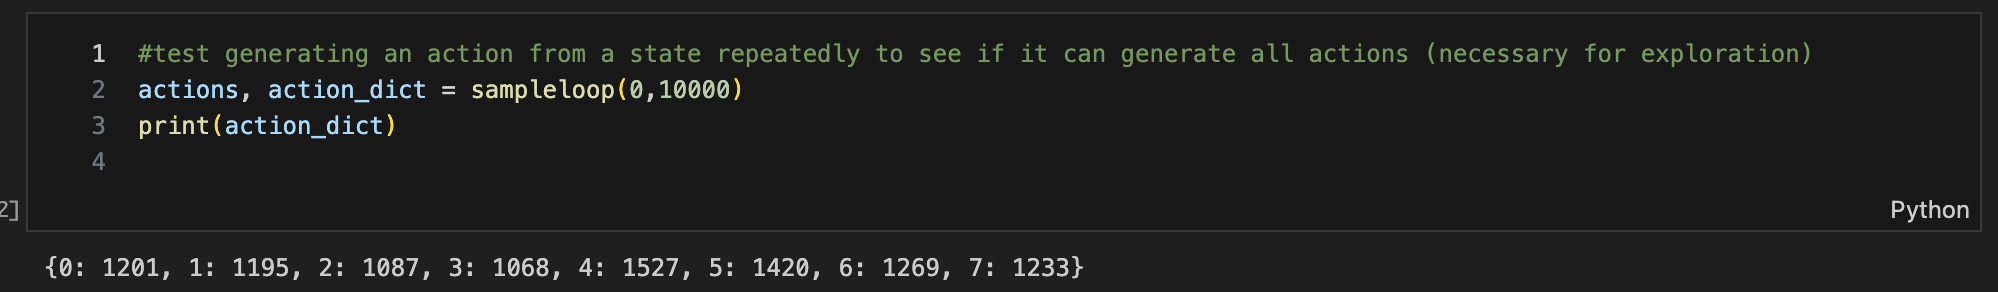

In [82]:
#test generating an action from a state repeatedly to see if it can generate all actions (necessary for exploration)
actions, action_dict = sampleloop(0,1000)
print(action_dict)


{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 1000, 6: 0, 7: 0}


In [218]:
#diffusion_model = torch.load("10K_T50_model.pt")

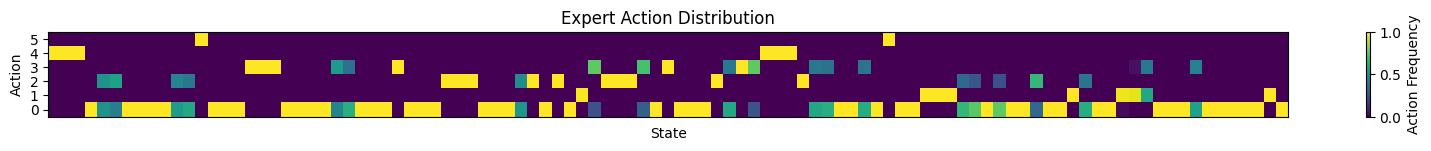

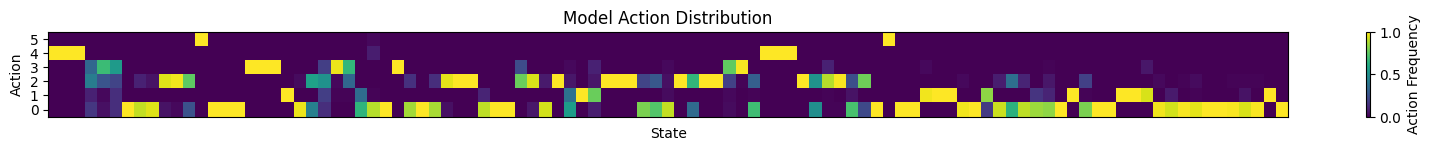

In [439]:
# Extract states and actions
states = data[:, 0].astype(int)
actions = data[:, 1].astype(int)

# Find unique states and actions
unique_states = np.unique(states)
num_actions = len(np.unique(actions))

# Initialize matrix to store action frequencies
action_frequency = np.zeros((num_actions, 101))

# Calculate the frequency of each action for each state
for i, state in enumerate(unique_states):
    state_actions = actions[states == state]
    for action in state_actions:
        action_frequency[action, i] += 1

    if i == 100:
        break

# Normalize the frequencies to get probabilities
action_frequency /= np.maximum(action_frequency.sum(axis=0), 1)  # Avoid division by zero

# Plotting the heatmap using pcolormesh
plt.figure(figsize=(20, 1.1))  # Adjust size as needed
plt.pcolormesh(action_frequency, cmap='viridis')
#shrink y axis (grid is stretched)
plt.ylim(0, 6)
plt.colorbar(label='Action Frequency')
plt.title('Expert Action Distribution')
plt.xlabel('State')
plt.ylabel('Action')
plt.yticks(np.arange(0.5, num_actions + 0.5, 1), np.arange(num_actions))
plt.xticks([])  # Remove x-ticks
plt.show()

# Calculate action frequencies for the model
model_action_frequency = np.zeros((num_actions, 101))

for i, state in enumerate(unique_states):
    if i > 100:
        break
    _, action_dict = sampleloop(loaded_model, state, 100, T=5)
    for action, count in action_dict.items():
        if action > 5:
            continue
        model_action_frequency[action, i] = count

# Normalize the frequencies
model_action_frequency /= np.maximum(model_action_frequency.sum(axis=0), 1)

#print(model_action_frequency)
# Plotting the heatmap for the model
plt.figure(figsize=(20, 1.1))
plt.pcolormesh(model_action_frequency, cmap='viridis')
plt.ylim(0, 6)
plt.colorbar(label='Action Frequency')
plt.title('Model Action Distribution')
plt.xlabel('State')
plt.ylabel('Action')
plt.yticks(np.arange(0.5, num_actions + 0.5, 1), np.arange(num_actions))
plt.xticks([])  # Remove x-ticks
plt.show()



In [252]:
#load model 
#diffusion_model = torch.load("3K-taxi-mixed.pt")

In [466]:
path_medium = 'taxi_q_medium_dataset.csv'
path_me= 'taxi_medium-expert_dataset.csv'

#medium_data = np.loadtxt(path_medium, delimiter=',', skiprows=1, converters={4: lambda x: int(x == 'True')})
mixed_data = np.loadtxt(path_me, delimiter=',', skiprows=1, converters={4: lambda x: int(x == 'True')})

states = mixed_data[:, 0].astype(int)
actions = mixed_data[:, 1].astype(int)

# create dict for each state state: [actions]
state_actions_dict = {}

for i, state in enumerate(states):
    if state not in state_actions_dict:
        state_actions_dict[state] = []
    state_actions_dict[state].append(actions[i])

# find states with more than 1 action type (ambiguous states)


ambiguous_states = []
count = 0
total = 0
wrong = 0 
wrongs = []
for state, actions in state_actions_dict.items():
    if len(set(actions)) > 1:
        ambiguous_states.append(state)
        action = analog2int(torch.sign(sample_action(diffusion_model, int2analog(state, 9), T=50)))
        #print("State: ", state, " | Actions: ", set(actions), " | Model Action: ", action)
        if action in actions:
            print(f"State: {state}, Both Actions: {set(actions)}", end="")
            print("  |  Majority Action: ", max(set(actions), key=actions.count), end="")
            print("  |  Model Action: ", action)
        
            total += 1
            if action == max(set(actions), key=actions.count):
                count += 1
            else:
                print("WRONG: ")
                
        else:
            wrong += 1
            wrongs.append(action)


print("\n---------------------------")
print("Number of ambiguous states: ", len(ambiguous_states))
print("Number of correct ambiguous states: ", total, " | Percentage: ", total/len(ambiguous_states) * 100, "%")
print("Policy chooses majority action: ", count, " of ", total, " | Percentage: ", count/total * 100, "%")
        
    






State: 293, Both Actions: {0, 3}  |  Majority Action:  0  |  Model Action:  3
WRONG: 
State: 108, Both Actions: {0, 2}  |  Majority Action:  0  |  Model Action:  0
State: 236, Both Actions: {1, 3}  |  Majority Action:  1  |  Model Action:  1
State: 88, Both Actions: {0, 2}  |  Majority Action:  2  |  Model Action:  2
State: 117, Both Actions: {0, 2}  |  Majority Action:  0  |  Model Action:  0
State: 369, Both Actions: {1, 2}  |  Majority Action:  1  |  Model Action:  1
State: 222, Both Actions: {1, 3}  |  Majority Action:  1  |  Model Action:  3
WRONG: 
State: 221, Both Actions: {1, 3}  |  Majority Action:  1  |  Model Action:  1
State: 123, Both Actions: {1, 3}  |  Majority Action:  1  |  Model Action:  1
State: 341, Both Actions: {1, 3}  |  Majority Action:  1  |  Model Action:  1
State: 104, Both Actions: {0, 2}  |  Majority Action:  0  |  Model Action:  2
WRONG: 
State: 147, Both Actions: {1, 2}  |  Majority Action:  1  |  Model Action:  1
State: 91, Both Actions: {0, 3}  |  Major

In [ ]:
#Dataset Statistics

#collect dataset statistics for analysis
dataset = np.loadtxt("taxi_q_expert_dataset.csv", delimiter=',', skiprows=1, converters={4: lambda x: int(x == 'True')})

#state distribution
state_dist1 = []
for i in range(len(dataset)):
    state_dist1.append(dataset[i][0])

#action distribution
action_dist1 = []
for i in range(len(dataset)):
    action_dist1.append(dataset[i][1])


#Dataset Statistics

#collect dataset statistics for analysis
dataset = np.loadtxt("taxi_mixed_dataset.csv", delimiter=',', skiprows=1, converters={4: lambda x: int(x == 'True')})

#state distribution
state_dist2 = []
for i in range(len(dataset)):
    state_dist2.append(dataset[i][0])

#action distribution
action_dist2 = []
for i in range(len(dataset)):
    action_dist2.append(dataset[i][1])


#print percentages of each action
for i in range(6):
    print(f"{i}: {(action_dist1.count(i)/len(action_dist1) * 100):.2f}% ({action_dist1.count(i)})   |  {(action_dist2.count(i)/len(action_dist2) * 100):.2f}% ({action_dist2.count(i)})")


# Notes

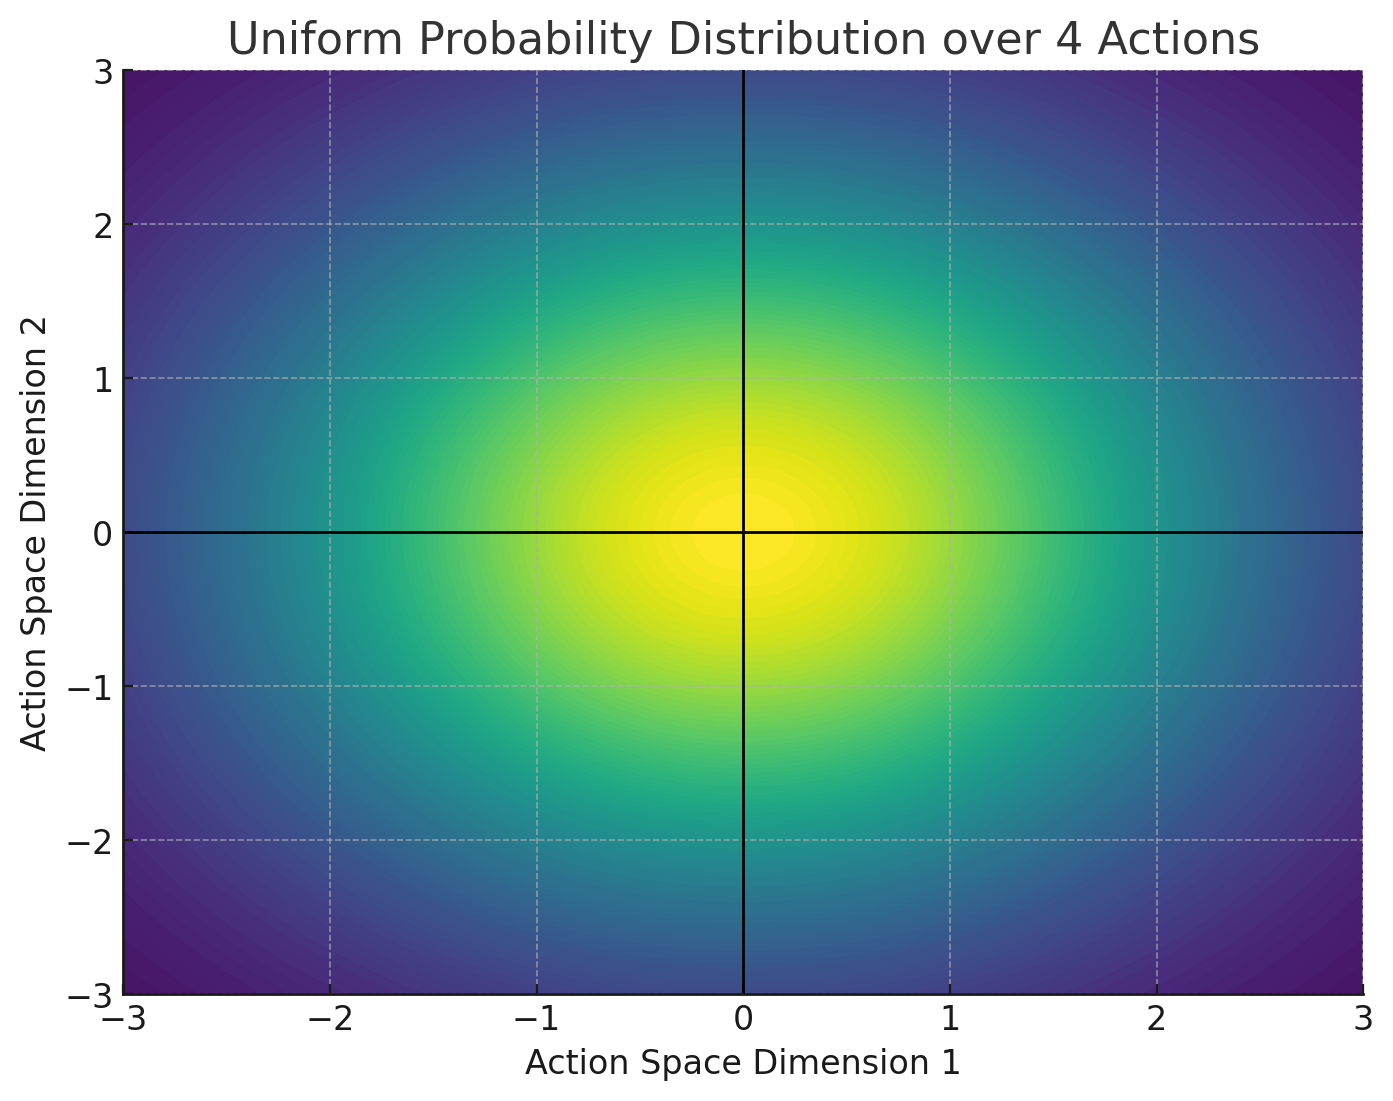
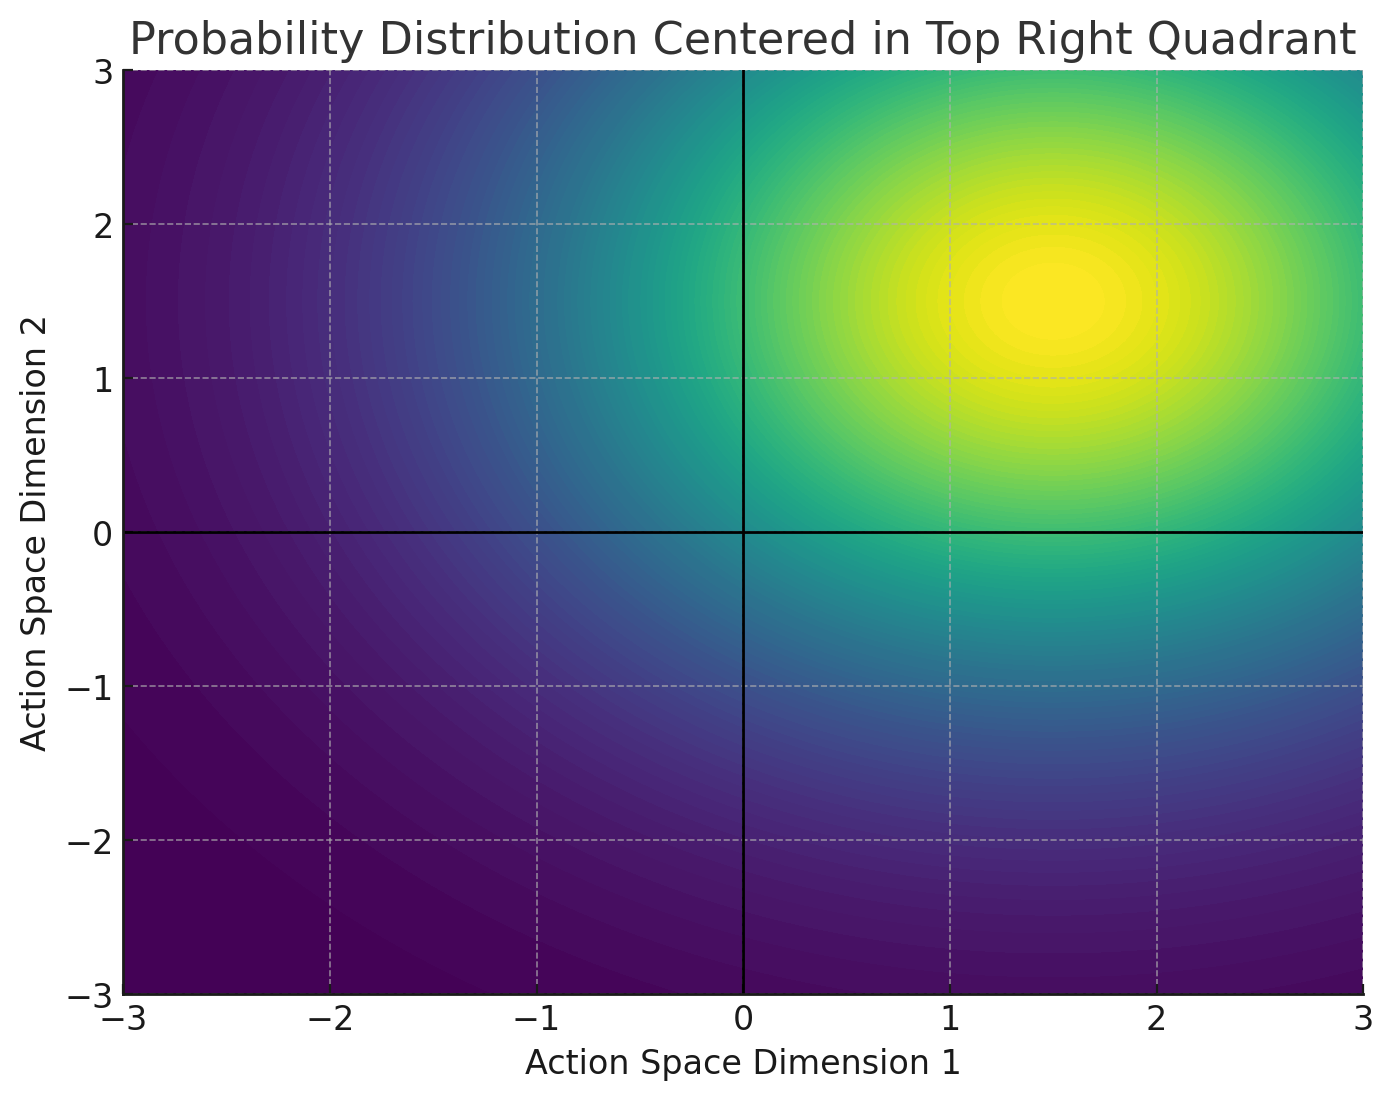

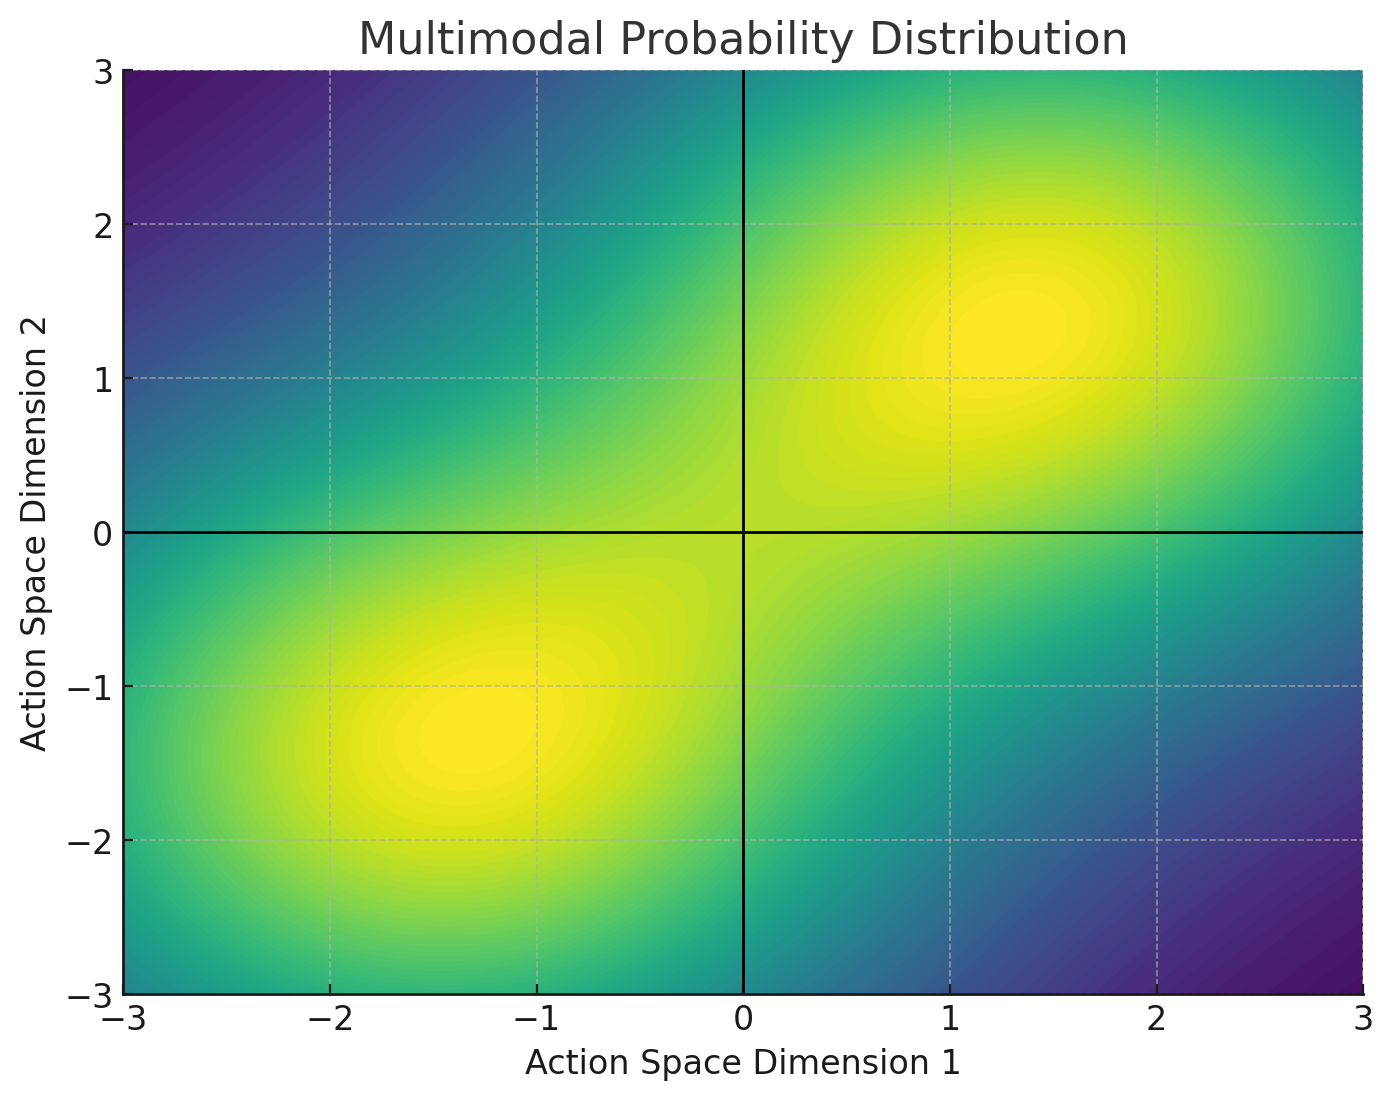
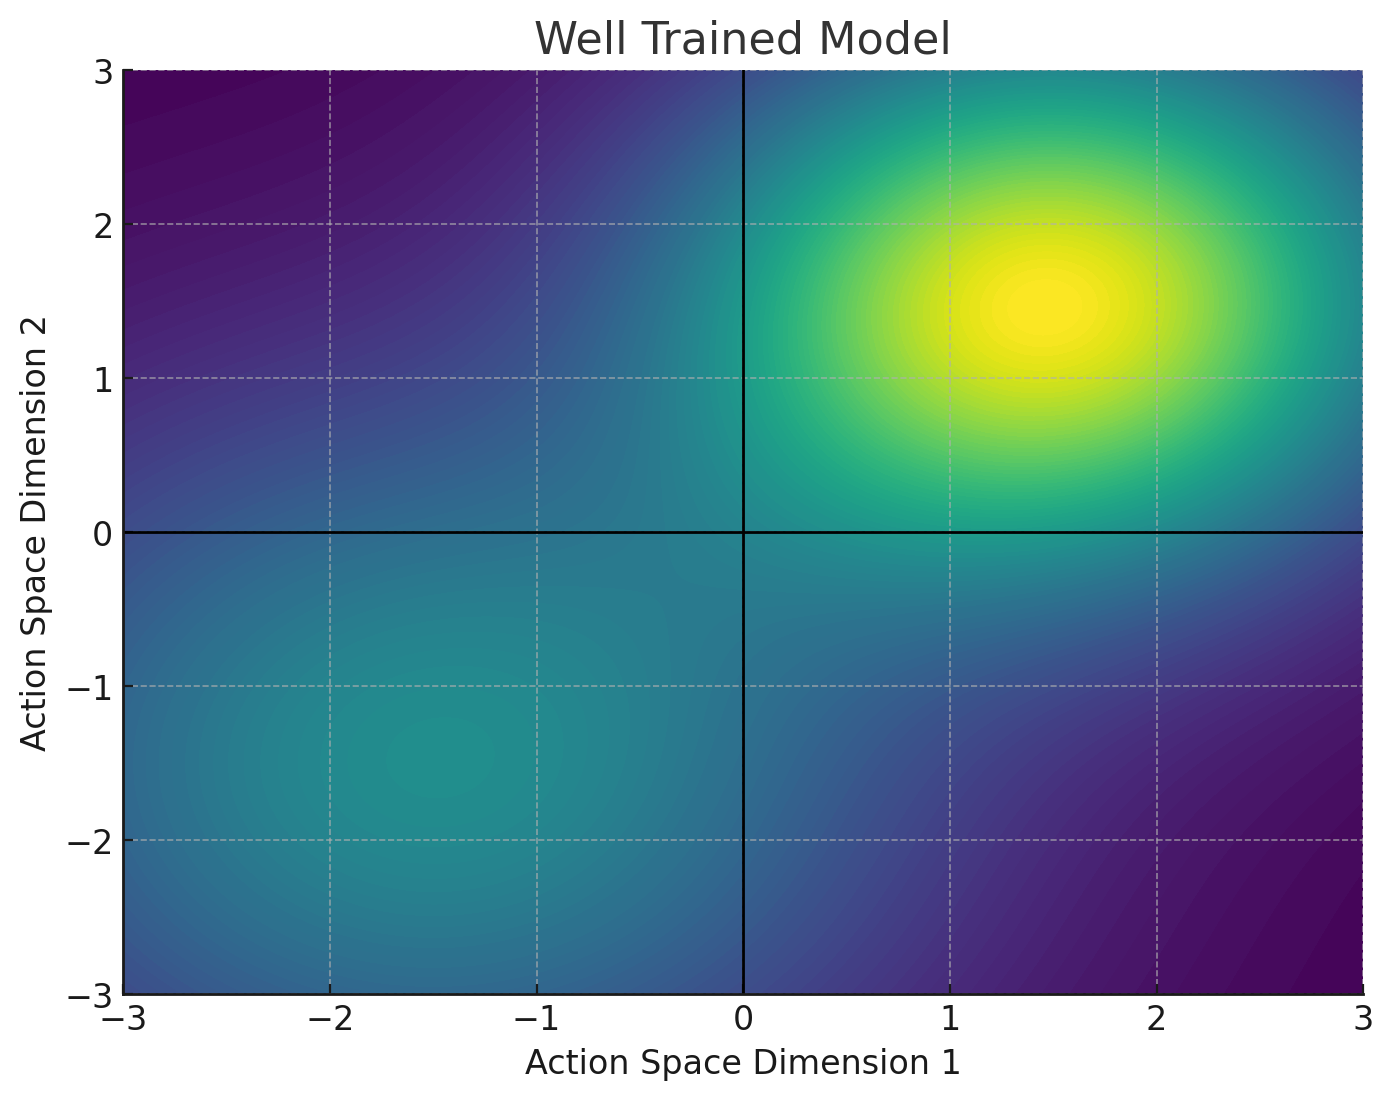

Before:

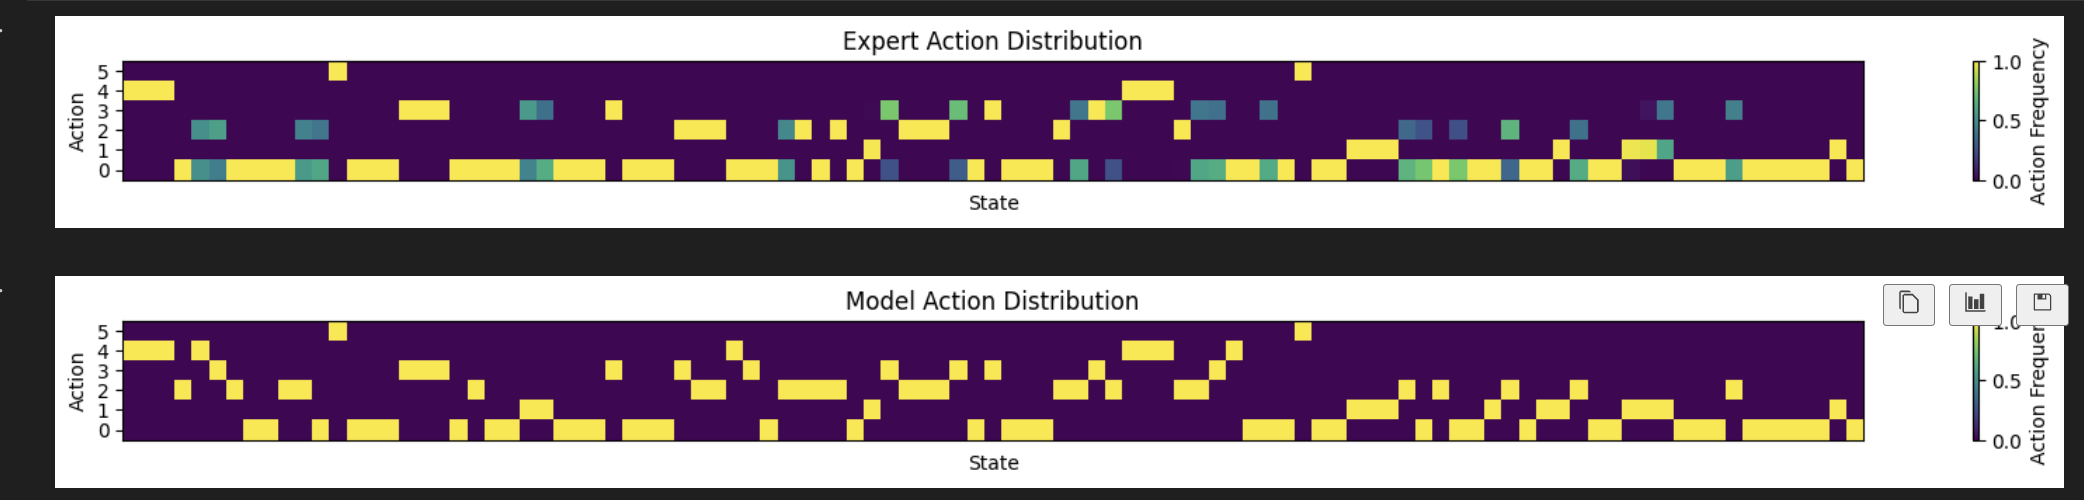

After:

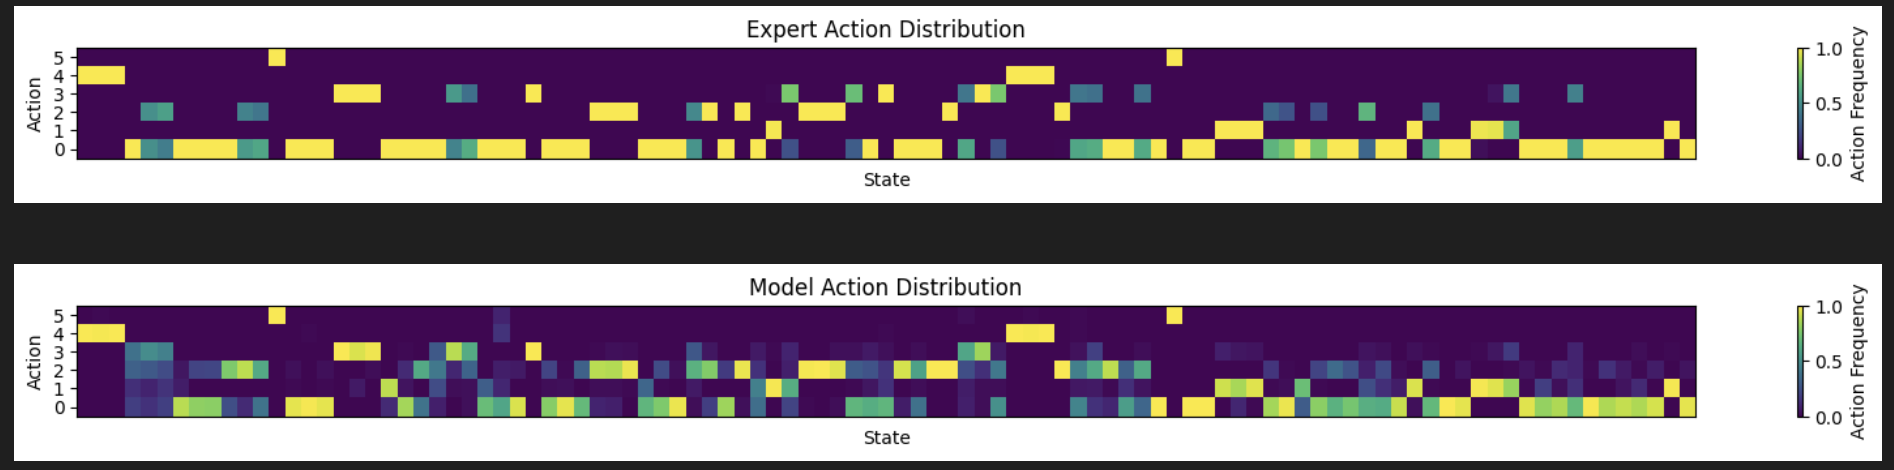